# Climate Scenario: Salt Water Intrusion due to Storm Surge
As extreme weather events increase in frequency and intensity, it is important to understand and model the impacts of these events on water infrastructure. This notebook illustrates how climate datasets can be used with WNTR to explore the impact of climate change on a water distribution system. 

In this notebook, storm surge data is used to simulate salt water intrusion to a water distribution system (WDS) during a hurricane.

## Storm surge dataset
The storm surge data used in this notebook are derived from the SLOSH (Sea, Lake, and Overland Surges from Hurricanes) model, which is used by the National Weather Service to estimate storm surge during hurricanes. The derived dataset uses multiple scenarios from stochastic runs of the SLOSH model to determine worst case storm surge projections. This [webpage](https://epa.maps.arcgis.com/apps/MapSeries/index.html?appid=852ca645500d419e8c6761b923380663) provided by the EPA provides additional information about these datasets under the "Details" tab and interactive exploration of the data under the "Storm Surge Flooding". This notebook uses the storm surge data for category 1 hurricanes, but higher categories could also be used.


## Scenario generation

The scenario generated in this notebook uses storm surge values to determine salt water intrusion points across the WDS model. The salt water intrusion is modelled using SETPOINT sources to inject salt water into the system at junctions inundated by the storm. The salt water density is linearly distributed with junctions that are not inundated by storm surge have a density of 0 and junctions that are inundated by the maximum level of storm surge assigned a salt density of 35 kg / m^3.

(Add some caveat about the simplicity of the simulation)
It is important to note that this scenario is simplistic and does not reflect realistic modelling conditions. More detailed analysis is outside the scope of this notebook, but could be pursued by following the methodology laid out by Moglen et. al. in their paper titled ["A nexus approach to infrastructure resilience planning under uncertainty"](https://www.sciencedirect.com/science/article/pii/S0951832022005464). This work (TODO brief explanation of their approach).

# 1. Load and visualize data

## 1.1 Initialization
Import WNTR and other relevant Python packages.

In [346]:
import wntr
import pandas as pd
import numpy as np
import rasterio as rs
import matplotlib.pyplot as plt
# import contextily as cx

from rasterio.plot import show
from os.path import join

In [347]:
inundation_cmap = "Blues"

1.2 Load water network model

The water network is loaded in first so that the network's geospatial extent can be extracted from the node geometries.

In [348]:
network_path = "../data/coastal_ky4.inp"
wn = wntr.network.WaterNetworkModel(network_path) 
gis = wn.to_gis(crs="EPSG:4269")

all_nodes = pd.concat((gis.junctions, gis.tanks, gis.reservoirs))
min_lon, min_lat, max_lon, max_lat = all_nodes.total_bounds

## 1.3 Load storm surge raster
To download the storm surge data, navigate to the following [webpage](https://www.nhc.noaa.gov/nationalsurge/) on NOAA's website. Scroll down to the "Data Availability and Download" section and use the link labeled "Texas to Maine (high tide scenario)" to obtain a zip file containing the storm surge scenarios. Unzip the folder and adjust the `raster_path` variable below to point to the folder's location. 

For the purposes of this notebook, a cropped version of the dataset at the example network is used to keep data sizes small.

Load in raster data using the extent of the water network.

In [349]:
raster_path = join("..", "data", "coastal_ky4_storm_surge.tif")
# raster_path = join("US_SLOSH_MOM_Inundation_v3", "us_Category1_MOM_Inundation_HIGH.tif") # modify this if using the data from NOAA

with rs.open(raster_path) as src:
    window = rs.windows.from_bounds(min_lon, min_lat, max_lon, max_lat, src.transform)
    
    inundation_raster = src.read(1, window=window)
    raster_transform = src.window_transform(window)
    raster_crs = src.crs

Raster data is converted to float and missing data values (255) are converted to NaN. 

In [350]:
inundation_raster = inundation_raster.astype(float) # change dtype from int to float to allow for NaN value
inundation_raster[inundation_raster==255] = np.nan # 255 indicates no data

## 1.3 Visualize data

Plot the raster data. The

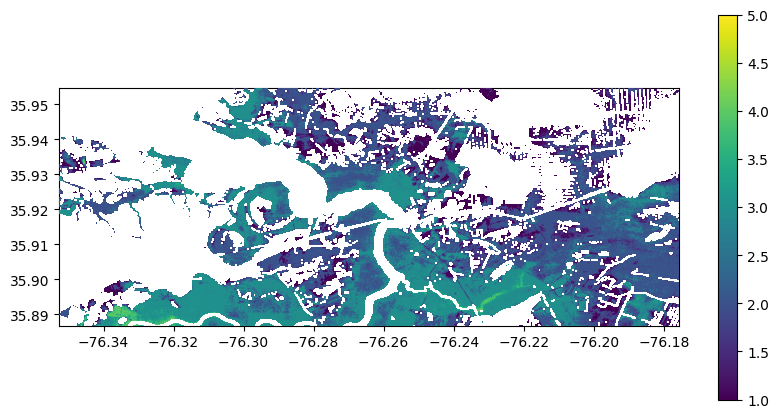

In [351]:
fig, ax = plt.subplots(figsize=(10,10))
imshow = show(inundation_raster, transform=raster_transform, ax=ax, zorder=5)
im = imshow.get_images()[0]
fig.colorbar(im, ax=ax, shrink=0.5)


Plot the water network model.

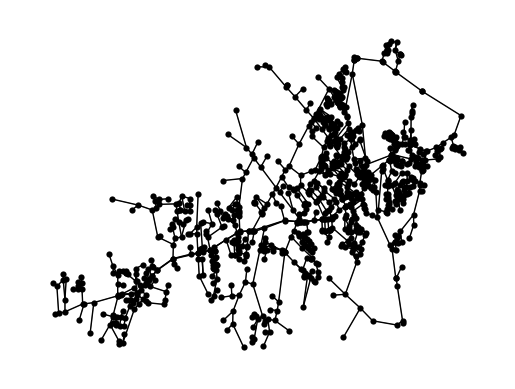

In [352]:
fig, ax = plt.subplots()
ax = wntr.graphics.plot_network(wn, ax=ax, show_plot=False)

## 2. Associate storm surge data to model

WNTR's `sample_raster` function provides a way to associate raster values to point geometries, such as junctions.

In [353]:
junctions = gis.junctions
junctions['inundation_level'] = wntr.gis.sample_raster(junctions, raster_path, bands=1)

Plot nodes with sea level value

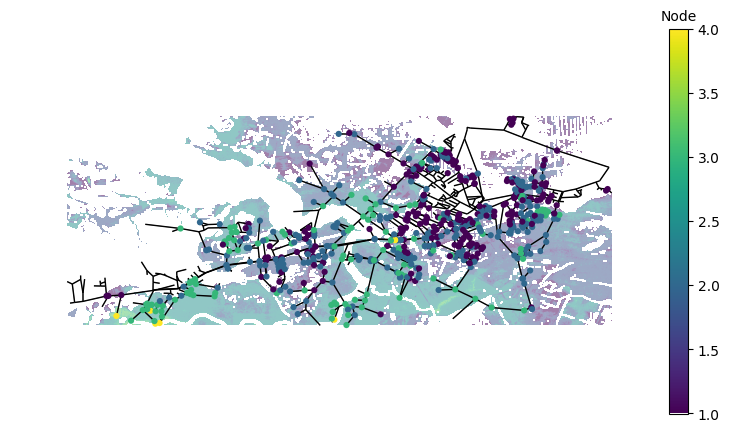

<Axes: >

In [354]:
fig, ax = plt.subplots(figsize=(10,10))

# plot storm surge data
im = show(inundation_raster, transform=raster_transform, 
          vmin=np.nanmin(inundation_raster), vmax=np.nanmax(inundation_raster), 
          ax=ax, alpha=0.5)

# plot junctions with associated inundation level
# junctions.plot(ax=ax, column="inundation_level", edgecolor="black", 
#                markersize=50, vmin=np.nanmin(inundation_raster), 
#                vmax=np.nanmax(inundation_raster), legend=True, 
#                legend_kwds={"shrink": 0.5})
wntr.graphics.plot_network(wn, node_attribute=junctions["inundation_level"], node_cmap="viridis", ax=ax)

## 3. Simulate salt water intrusion
To model saltwater intrusion at each junction, the level of sea water inundation is used to determine the amount of salt water entering the system at each junction. The density of salt in sea water is 35 kg/m^3. In this analysis, the inundation bins levels from 0-6 are linearly converted to salt water densities with 0 having no salt water and 6 having the maximum density of salt water.

In [355]:
# set time options to run at hourly time steps for eight days
wn.options.time.hydraulic_timestep = 3600
wn.options.time.quality_timestep = 3600
wn.options.time.duration = 3600 * 192

In [356]:
# Estimate salt water intrustion rate using inundation levels
salt_water_flowrate = junctions["inundation_level"].copy()
salt_water_flowrate.name = "salt water flowrate"
# salt_water_flowrate = (salt_water_flowrate / 6) * 35 # kg / m^3
salt_water_flowrate[:] = - 0.0001 * salt_water_flowrate[:] # m3/s
print(salt_water_flowrate.head())


name
J-1     -0.0002
J-10        NaN
J-100       NaN
J-101   -0.0002
J-102       NaN
Name: salt water flowrate, dtype: float64


In [375]:
# #TODO plot relationship between raster levels (storm surge inundation) and salt water density
fig, ax = plt.subplots()
storm_surge_min = junctions['inundation_level'].min()
storm_surge_max = junctions['inundation_level'].max()
storm_surge_range = np.arange(storm_surge_min, storm_surge_max + 1, 1)
salt_density_range = storm_surge_range * 35 / 6 # kg / m^3
ax.plot(storm_surge_range, salt_density_range)
ax.set_xlabel("Storm Surge Inundation Level")
ax.set_ylabel("Salt water flowrate (m^3 / s)")

Text(0.5, 1.0, 'Distribution of salt water flowrate across nodes')

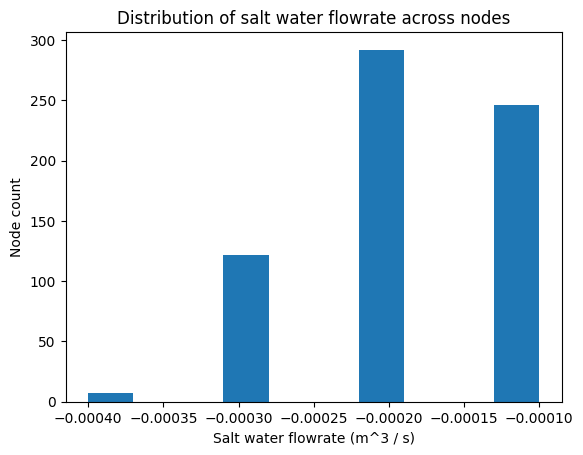

In [373]:
fig, ax = plt.subplots()
ax.hist(salt_water_flowrate)

ax.set_xlabel("Salt water flowrate (m^3 / s)")
ax.set_ylabel("Node count")
ax.set_title("Distribution of salt water flowrate across nodes")

In [359]:
# The salt water densities are used to create water quality sources in the model. 
# The pattern is set to activate at 2 hours into the simulation and deactivate at 22 hours.
# TODO experiment with and understand quality options better
storm_start = 2*3600
storm_end = 22*3600
source_pattern = wntr.network.elements.Pattern.binary_pattern('StormSurge',
    start_time=storm_start, end_time=storm_end, duration=wn.options.time.duration,
    step_size=wn.options.time.pattern_timestep)

wn.add_pattern('StormSurge', source_pattern)

In [360]:
# Add a source at each junction using the estimated flow rates

inundated = salt_water_flowrate < 0.0
salt_water_density = 35 # kg/m3 
for junction_name in wn.junction_name_list:
    if inundated[junction_name]:
        junction = wn.get_node(junction_name)
        wn.add_source(f'Source_{junction_name}', junction_name, 'CONCEN', salt_water_density, 'StormSurge')
        junction.add_demand(base=salt_water_flowrate[junction_name], pattern_name='StormSurge')
        print(junction_name, junction.base_demand, salt_water_flowrate[junction_name])


J-1 0.00015709458903600003 -0.0002
J-101 1.57725491e-05 -0.0002
J-105 8.832627496000001e-06 -0.0002
J-106 6.0566588544e-05 -0.0001
J-107 2.208156874e-05 -0.0002
J-108 5.993568658e-05 -0.0001
J-110 3.3437804092e-05 -0.0001
J-111 0.000148892863504 -0.0002
J-112 0.000105360627988 -0.0001
J-113 4.7948549264e-05 -0.0002
J-114 2.9652392308e-05 -0.0002
J-117 1.9557960884e-05 -0.0002
J-118 4.9210353192000005e-05 -0.00030000000000000003
J-12 1.8296156956e-05 -0.0002
J-121 5.678117676e-06 -0.0002
J-122 4.1639529624e-05 -0.0002
J-124 3.0283294272e-05 -0.0002
J-125 8.580266710400001e-05 -0.00030000000000000003
J-126 3.9746823732000005e-05 -0.0002
J-127 7.7600941572e-05 -0.0002
J-128 2.9652392308e-05 -0.00030000000000000003
J-129 1.7034353028e-05 -0.0002
J-13 2.7128784452000003e-05 -0.0001
J-130 3.5961411948e-05 -0.0001
J-135 0.000338794354668 -0.0002
J-136 5.047215712000001e-05 -0.0001
J-137 7.003011800400001e-05 -0.0001
J-138 5.8673882652000004e-05 -0.0001
J-14 1.5141647136e-05 -0.0001
J-140 5.93

In [361]:
# Set parameter type for quality simulation and add a name for the chemical
wn.options.quality.parameter = "CHEMICAL"
wn.options.quality.chemical_name = "NaCl"

Baseline simulation

In [362]:
# Simulate hydraulics and water quality
sim = wntr.sim.EpanetSimulator(wn)
baseline_results = sim.run_sim()

In [363]:
baseline_quality = baseline_results.node['quality']
# baseline_quality.index = baseline_quality.index / 3600

Text(0, 0.5, 'Salt water density (kg/m^3)')

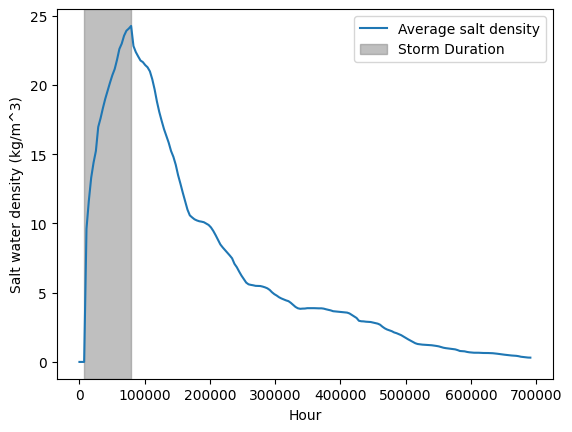

In [364]:
# Plot results
fig, ax = plt.subplots()
baseline_quality.mean(axis=1).plot(ax=ax, label="Average salt density")
ax.axvspan(storm_start, storm_end, color='grey', alpha=0.5, label="Storm Duration")
ax.legend()
ax.set_xlabel("Hour")
ax.set_ylabel("Salt water density (kg/m^3)")

Response simulation

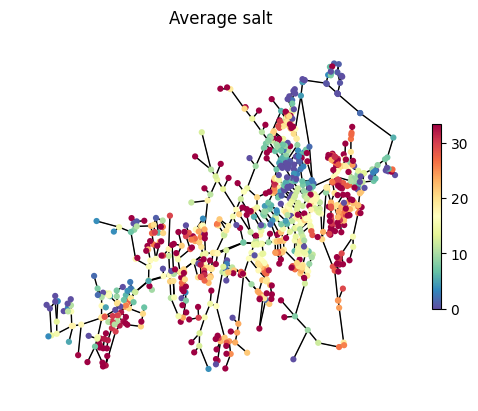

<Axes: title={'center': 'Average salt'}>

In [365]:
# plot average salt water and choose a hydrant in high density area
avg_salt_water = baseline_quality.loc[storm_start:storm_end].mean(axis=0)
wntr.graphics.plot_network(wn, node_attribute=avg_salt_water, node_colorbar_label="", title="Average salt")

In [366]:
# hydrant_nodes = ["J-510"]
# hydrant_nodes = []
hydrant_nodes = ["J-510", "J-408", "J-223", "J-166"]
# hydrant_nodes = ["J-510", "J-408", "J-223", "J-166", "J-595", "J-777", "J-24", "J-419"]

# fire_flow_demand = 0.126 # 2000 gal/min 
fire_flow_demand = 0.126 # 2000 gal/min
hydrant_start = storm_end
hydrant_end = storm_end + 72 * 3600

for hydrant_node in hydrant_nodes:
    junction = wn.get_node(hydrant_node)
    junction.add_fire_fighting_demand(wn, fire_flow_demand, hydrant_start, hydrant_end)

Plot hydrant locations

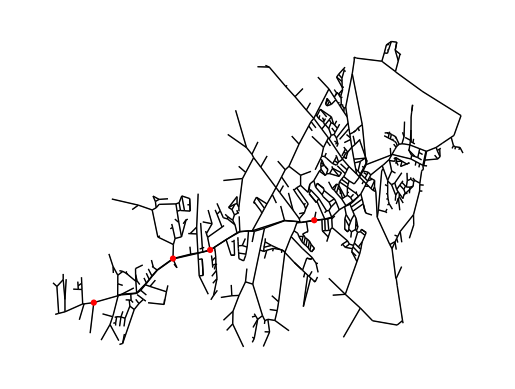

<Axes: >

In [367]:
wntr.graphics.plot_network(wn, node_attribute=hydrant_nodes)

In [368]:
sim = wntr.sim.EpanetSimulator(wn)
response_results = sim.run_sim()
response_quality = response_results.node['quality']

Text(0, 0.5, 'Salt water density (kg/m^3)')

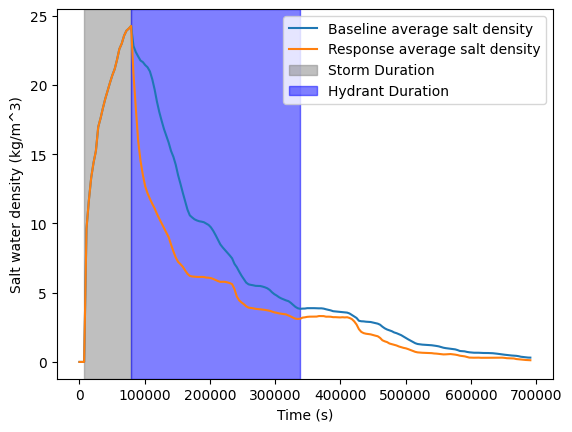

In [370]:
# Plot results
fig, ax = plt.subplots()
baseline_quality.mean(axis=1).plot(ax=ax, label="Baseline average salt density")
response_quality.mean(axis=1).plot(ax=ax, label="Response average salt density")
ax.axvspan(storm_start, storm_end, color='grey', alpha=0.5, label="Storm Duration")
ax.axvspan(hydrant_start, hydrant_end, color='blue', alpha=0.5, label="Hydrant Duration")
ax.legend()
ax.set_xlabel("Time (s)")
ax.set_ylabel("Salt water density (kg/m^3)")

In [371]:
# # %matplotlib tk
# # these plots are pretty finnicky in notebooks, might be better to save file?
# # TODO add labels to plot
# plt.rcParams["animation.html"] = "jshtml"

# from IPython.display import display
# anim = wntr.graphics.network_animation(wn, node_attribute=baseline_quality, title="Salt Concentration") 
# display(anim)